# Playing BlackJack with First Visit MC

Approximation of a value table when the model/mechanics/reward of the environment after each action is unknown (e.g. you don know is taking a hit/stand in blackjack helpful to your game only until you have won or otherwise, lost the game). Suitable for only episodic tasks.

 First, let us import all the necessary libraries

In [1]:
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

 Simulate the Blackjack environment

 Actions Available
 - Hit : Add new card (1)
 - Stand : Dont add new card (0)

 Rewards Available
 - Draw : No one wins or lose (0)
 - Win : Player sum more than dealer sum (1)
 - Lose : Player sum more than 21 or dealer has higher sum (-1)

In [2]:
env = gym.make('Blackjack-v1')

Then we define the policy function which takes the current state and check if the score is
greater than or equal to 20, if yes we return 0 else we return 1. i.e If the score is greater
than or equal to 20 we stand (0) else we hit (1)

In [3]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

We define a function called generate_episode for generating epsiodes

In [4]:
def generate_episode(policy, env):
    
    # we initialize the list for storing states, actions, and rewards
    states, actions, rewards = [], [], []
    
    # Initialize the gym environment
    observation = env.reset()
    
    while True:
        
        # append the states to the states list
        states.append(observation)
        
        # now, we select an action using our sample_policy function and append the action to actions list
         
        action = sample_policy(observation)
        actions.append(action)
        
        # We perform the action in the environment according to our sample_policy, move to the next state 
        # and receive reward
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        
        # Break if the state is a terminal state
        if done:
             break
                
    return states, actions, rewards

 Now that we learned how to generate an episode, we will see how to perform First Vist MC Prediction

In [9]:
def first_visit_mc_prediction(policy, env, n_episodes):
    
    # First, we initialize the empty value table as a dictionary for storing the values of each state
    value_table = defaultdict(float) # Store value of each state
    N = defaultdict(int) # Store number of observed occurence for each state

    
    for _ in range(n_episodes):
        
        # Next, we generate the epsiode and store the states and rewards
        states, _, rewards = generate_episode(policy, env)
        returns = 0
        
        # Then for each step, we store the rewards to a variable R and states to S, and we calculate
        # returns as a sum of rewards
        '''
        The calculation is done in backward orders because a return of each state takes into account of
        the sum of all future returns
        e.g. (In Chronology Order) State Format : (Player Sum, Dealer 1st Card, Usable Ace)
        1st Step: (8, 7, 0) -> Action Hit (1) -> Reward 0
        2nd Step: (20, 7, 0) -> Action Stand (0) -> Reward 1
        Hence, we can say that the reward of the 1st step should be (0+1 = 1) as the decision finally lead 
        to a victory.
        '''
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t] # Record Immediate Rewards
            S = states[t] # Record Current State

            returns += R # Record returns as sum of all future rewards
            
            # Now to perform first visit MC, we check if the episode is visited for the first time, if yes,
            # we simply take the average of returns and assign the value of the state as an average of returns
            
            if S not in states[:t]: # Only take consideration of the first occurance of the state in the current episode
                N[S] += 1
                # Update the value of the state by adding the difference of the returns and
                # stored value divided by the number of occurrence of the given state
                value_table[S] += (returns - value_table[S]) / N[S] 
            else:
                print("Same State Repeated in an Episode")
                print(S, R)
    
    return value_table

In [7]:
value = first_visit_mc_prediction(sample_policy, env, n_episodes=500000)

Let us see first few elements in the value table

> Because the policy taken is to Stand (Dont take a card) when the player_sum (First element) is more than 20, that's why positive return is observed

In [15]:
positive_returns = {state:state_val for state, state_val in value.items() if state_val>0}
print(len(positive_returns))
positive_returns

40


{(20, 10, False): 0.43523454157782476,
 (21, 4, False): 0.890698896479242,
 (20, 5, True): 0.6703296703296705,
 (20, 5, False): 0.6810945928167339,
 (21, 10, True): 0.91760540714516,
 (20, 1, False): 0.14083575773604862,
 (21, 3, False): 0.876835867044578,
 (20, 4, False): 0.6666224814422049,
 (21, 7, False): 0.9272258064516136,
 (21, 1, False): 0.6355188435725371,
 (21, 2, False): 0.8839545334390697,
 (21, 1, True): 0.6753359341135666,
 (20, 7, True): 0.7748633879781429,
 (20, 8, False): 0.7866649097377769,
 (21, 7, True): 0.9874838152783774,
 (20, 6, False): 0.7204171680705969,
 (20, 9, False): 0.7616025386751294,
 (21, 5, False): 0.8937401367701236,
 (20, 2, True): 0.6410810810810805,
 (21, 2, True): 0.9756097560975616,
 (21, 8, True): 0.9840996991834986,
 (21, 10, False): 0.8882449785973006,
 (20, 7, False): 0.7723064537770035,
 (21, 3, True): 0.9766553480475373,
 (21, 6, False): 0.9049999999999997,
 (20, 6, True): 0.7192008879023327,
 (20, 3, False): 0.6455815202793429,
 (20, 1, T

In [7]:
for i in range(10):
  print(value.popitem())

((7, 1, False), -0.6222222222222212)
((4, 7, False), -0.4941634241245135)
((18, 6, False), -0.6950909090909095)
((6, 7, False), -0.5026595744680847)
((17, 8, True), -0.38016528925619797)
((20, 6, False), 0.6994790971016418)
((8, 9, False), -0.5072024260803637)
((4, 4, False), -0.5106382978723403)
((13, 1, False), -0.670459424645771)
((12, 10, True), -0.28959276018099556)


 We define the function plot_blackjack for plotting the value function and we can see how our value function is attaining the convergence. 

In [38]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace] # Append the valuefunc for each state available
    
    X, Y = np.meshgrid(dealer_show, player_sum)
 
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
 
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')
        

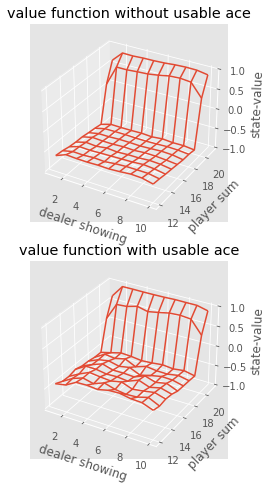

In [39]:
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8),
subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(value, axes[0], axes[1])

From the graph we can observe that the **rewards increases sharply** (*from the y-axis as the x-axis is pointless given the naive policy that we defined*) when the **player sum is more than 20** as that is when action **Stand is taken instead of Hit**.

Playing with Blackjacks

In [12]:
observation = env.reset()
observation

(13, 2, False)

In [13]:
env.step(0)

((13, 2, False), -1.0, True, {})